In [3]:
import numpy as np
from common.functions import *
class LSTM:
    def __init__(self, wx, wh, b):
        self.params = [wx, wh, b]
        self.grads = [np.zeros_like(wx), np.zeros_like(wh), np.zeros_like(b)]
        self.cache = None
    def forward(self, x, h_prev, c_prev):
        wx, wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, wx) + np.matmul(h_prev, wh) + b
        
        f, g, i, o = A[:, :H], A[:, H:2*H], A[:, 2*H:3*H], A[:, 3*H:]
        f, i, o = sigmoid(f), sigmoid(i), sigmoid(o)
        g = np.tanh(g)
        
        c_next = c_prev * f + g * i
        h_next = np.tanh(c_next) * o
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    def backward(self, dh_next, dc_next):
        wx, wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next**2)
        
        dc_prev = f * ds
        di = g * ds
        df = c_prev * ds
        do = tanh_c_next * dh_next
        dg = i * ds
        
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)
        
        dA = np.hstack((df, dg, di, do))
        
        db = dA.sum(axis=0)
        dwh = np.dot(h_prev.T, dA)
        dwx = np.dot(x.T, dA)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

In [4]:
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.45
| 에폭 1 |  반복 21 / 1327 | 시간 11[s] | 퍼플렉서티 2954.75
| 에폭 1 |  반복 41 / 1327 | 시간 21[s] | 퍼플렉서티 1244.62
| 에폭 1 |  반복 61 / 1327 | 시간 32[s] | 퍼플렉서티 994.43
| 에폭 1 |  반복 81 / 1327 | 시간 42[s] | 퍼플렉서티 793.69
| 에폭 1 |  반복 101 / 1327 | 시간 53[s] | 퍼플렉서티 661.21
| 에폭 1 |  반복 121 / 1327 | 시간 63[s] | 퍼플렉서티 645.16
| 에폭 1 |  반복 141 / 1327 | 시간 67[s] | 퍼플렉서티 603.90
| 에폭 1 |  반복 161 / 1327 | 시간 72[s] | 퍼플렉서티 581.62
| 에폭 1 |  반복 181 / 1327 | 시간 76[s] | 퍼플렉서티 581.81
| 에폭 1 |  반복 201 / 1327 | 시간 80[s] | 퍼플렉서티 510.47
| 에폭 1 |  반복 221 / 1327 | 시간 84[s] | 퍼플렉서티 494.00
| 에폭 1 |  반복 241 / 1327 | 시간 88[s] | 퍼플렉서티 454.25
| 에폭 1 |  반복 261 / 1327 | 시간 92[s] | 퍼플렉서티 464.76
| 에폭 1 |  반복 281 / 1327 | 시간 97[s] | 퍼플렉서티 458.24
| 에폭 1 |  반복 301 / 1327 | 시간 101[s] | 퍼플렉서티 389.13
| 에폭 1 |  반복 321 / 1327 | 시간 105[s] | 퍼플렉서티 348.14
| 에폭 1 |  반복 341 / 1327 | 시간 109[s] | 퍼플렉서티 401.40
| 에폭 1 |  반복 361 / 1327 | 시간 113[s] | 퍼플렉서티 409.09
| 에폭 1 |  반복 381 / 1327 | 시간 118[s] | 퍼플렉서티 342.11

| 에폭 3 |  반복 541 / 1327 | 시간 738[s] | 퍼플렉서티 137.17
| 에폭 3 |  반복 561 / 1327 | 시간 743[s] | 퍼플렉서티 120.05
| 에폭 3 |  반복 581 / 1327 | 시간 747[s] | 퍼플렉서티 105.31
| 에폭 3 |  반복 601 / 1327 | 시간 752[s] | 퍼플렉서티 148.94
| 에폭 3 |  반복 621 / 1327 | 시간 756[s] | 퍼플렉서티 143.32
| 에폭 3 |  반복 641 / 1327 | 시간 761[s] | 퍼플렉서티 130.11
| 에폭 3 |  반복 661 / 1327 | 시간 765[s] | 퍼플렉서티 120.67
| 에폭 3 |  반복 681 / 1327 | 시간 769[s] | 퍼플렉서티 101.01
| 에폭 3 |  반복 701 / 1327 | 시간 774[s] | 퍼플렉서티 119.92
| 에폭 3 |  반복 721 / 1327 | 시간 778[s] | 퍼플렉서티 127.07
| 에폭 3 |  반복 741 / 1327 | 시간 783[s] | 퍼플렉서티 108.21
| 에폭 3 |  반복 761 / 1327 | 시간 787[s] | 퍼플렉서티 104.23
| 에폭 3 |  반복 781 / 1327 | 시간 792[s] | 퍼플렉서티 106.03
| 에폭 3 |  반복 801 / 1327 | 시간 796[s] | 퍼플렉서티 116.10
| 에폭 3 |  반복 821 / 1327 | 시간 800[s] | 퍼플렉서티 117.07
| 에폭 3 |  반복 841 / 1327 | 시간 805[s] | 퍼플렉서티 115.86
| 에폭 3 |  반복 861 / 1327 | 시간 809[s] | 퍼플렉서티 120.64
| 에폭 3 |  반복 881 / 1327 | 시간 814[s] | 퍼플렉서티 106.92
| 에폭 3 |  반복 901 / 1327 | 시간 818[s] | 퍼플렉서티 133.47
| 에폭 3 |  반복 921 / 1327 | 시간 82

c:\users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\sinjy\

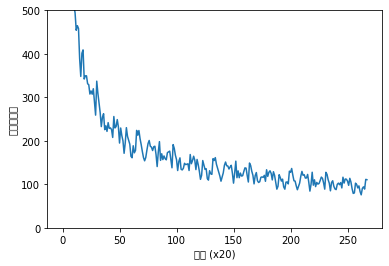

퍼플렉서티 평가 중 ...
234 / 235
test perplexity:  136.16468423543267


In [4]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
import ptb

batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

In [5]:
model.save_params()

In [5]:
class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, 
                hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_w = (rn(V, D) / 100).astype('f')
        lstm_wx1 = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_wh1 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4*H).astype('f')
        lstm_wx2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_wh2 = (rn(H, 4*H) / np.sqrt(H)).astype('f') 
        lstm_b2 = np.zeros(4*H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_w),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_wx1, lstm_wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_wx2, lstm_wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio), 
            TimeAffine(embed_w.T, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs, train_fig=False):
        for layer in self.drop_layers:
            layer.train_fig = train_fig
        
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_fig=True):
        score = self.predict(xs, train_fig)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [6]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
import ptb

batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
               time_size=time_size, max_grad=max_grad)
    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('val perplexity: ', ppl)
    
    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr
    model.reset_state()
    print('-'*50)

model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

| 에폭 1 |  반복 1 / 1327 | 시간 3[s] | 퍼플렉서티 9999.56
| 에폭 1 |  반복 21 / 1327 | 시간 93[s] | 퍼플렉서티 3738.23
| 에폭 1 |  반복 41 / 1327 | 시간 183[s] | 퍼플렉서티 1866.70
| 에폭 1 |  반복 61 / 1327 | 시간 231[s] | 퍼플렉서티 1274.88
| 에폭 1 |  반복 81 / 1327 | 시간 270[s] | 퍼플렉서티 1099.00
| 에폭 1 |  반복 101 / 1327 | 시간 309[s] | 퍼플렉서티 823.40
| 에폭 1 |  반복 121 / 1327 | 시간 348[s] | 퍼플렉서티 788.59
| 에폭 1 |  반복 141 / 1327 | 시간 387[s] | 퍼플렉서티 740.36
| 에폭 1 |  반복 161 / 1327 | 시간 426[s] | 퍼플렉서티 703.65
| 에폭 1 |  반복 181 / 1327 | 시간 465[s] | 퍼플렉서티 669.15
| 에폭 1 |  반복 201 / 1327 | 시간 504[s] | 퍼플렉서티 598.91
| 에폭 1 |  반복 221 / 1327 | 시간 544[s] | 퍼플렉서티 570.56
| 에폭 1 |  반복 241 / 1327 | 시간 583[s] | 퍼플렉서티 517.22
| 에폭 1 |  반복 261 / 1327 | 시간 622[s] | 퍼플렉서티 550.36
| 에폭 1 |  반복 281 / 1327 | 시간 663[s] | 퍼플렉서티 513.83
| 에폭 1 |  반복 301 / 1327 | 시간 702[s] | 퍼플렉서티 442.34
| 에폭 1 |  반복 321 / 1327 | 시간 738[s] | 퍼플렉서티 392.93
| 에폭 1 |  반복 341 / 1327 | 시간 775[s] | 퍼플렉서티 446.12
| 에폭 1 |  반복 361 / 1327 | 시간 811[s] | 퍼플렉서티 463.04
| 에폭 1 |  반복 381 / 1327 | 시간 847[s]

KeyboardInterrupt: 